In [103]:
import numpy as np
import xarray as xr
import nc_time_axis
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import tracks
%matplotlib inline

savefigkwargs = dict(transparent=True, dpi=300, bbox_inches='tight')
MONTHS_NH = [6,7,8,9,10]  # NH TC season months [1: Jan - 12: Dec]
MONTHS_SH = [1,2,3,4,5]   # SH TC season months

In [9]:
ds_tc = tracks.load_tracks('../../tracker/jobs/Tracking_TC_RV/', ext='')

REF.001: 5.000 years, 475 tracks
REF.002: 5.000 years, 484 tracks
REF.003: 5.000 years, 496 tracks
REF.004: 5.000 years, 500 tracks
REF.005: 5.000 years, 523 tracks
REF.006: 5.000 years, 462 tracks
RCP.001: 5.000 years, 445 tracks
RCP.002: 5.000 years, 437 tracks
RCP.003: 5.000 years, 459 tracks
RCP.004: 5.000 years, 464 tracks
RCP.005: 5.000 years, 455 tracks
RCP.006: 5.000 years, 473 tracks
SAI.001: 5.000 years, 425 tracks
SAI.002: 5.000 years, 430 tracks
SAI.003: 5.000 years, 412 tracks
SAI.004: 5.000 years, 430 tracks
SAI.005: 5.000 years, 406 tracks
SAI.006: 5.000 years, 421 tracks


In [10]:
ds_sd = tracks.load_tracks('../../tracker/jobs/Tracking_TC_RV.seeds2/', ext='.seeds2')

REF.001: 5.000 years, 2026 tracks
REF.002: 5.000 years, 2063 tracks
REF.003: 5.000 years, 2088 tracks
REF.004: 5.000 years, 2080 tracks
REF.005: 5.000 years, 2184 tracks
REF.006: 5.000 years, 2005 tracks
RCP.001: 5.000 years, 1854 tracks
RCP.002: 5.000 years, 1745 tracks
RCP.003: 5.000 years, 1698 tracks
RCP.004: 5.000 years, 1759 tracks
RCP.005: 5.000 years, 1808 tracks
RCP.006: 5.000 years, 1784 tracks
SAI.001: 5.000 years, 1697 tracks
SAI.002: 5.000 years, 1843 tracks
SAI.003: 5.000 years, 1795 tracks
SAI.004: 5.000 years, 1894 tracks
SAI.005: 5.000 years, 1783 tracks
SAI.006: 5.000 years, 1696 tracks


In [11]:
%%time
def link_seeds(ds_tc, ds_sd, name='sd_id'):
    """find ids of seed tracks in ds_sd that correspond to tc tracks in ds_tc, 
    storing as 'name' in ds_tc
    """

    if isinstance(ds_tc, dict):
        return {exp: link_seeds(ds_tc[exp], ds_sd[exp], name=name) for exp in ds_tc}

    uens = sorted(np.unique(ds_tc.ens))
    if len(uens) > 1:
        return xr.concat([link_seeds(
            ds_tc.where(ds_tc.ens==ens, drop=True),
            ds_sd.where(ds_sd.ens==ens, drop=True),
            name=name
        ) for ens in uens], dim='id')
        
    sd_tmin = ds_sd.time.min('dtime')
    sd_tmax = ds_sd.time.max('dtime')
    ds_tc[name] = ('id', np.full(ds_tc.id.size, np.nan))
    for tcid in ds_tc.id.data:
        tc0 = ds_tc.sel(id=tcid).isel(dtime=0, drop=True)
        sd_ids = (tc0.time >= sd_tmin) & (tc0.time <= sd_tmax)
        sds = ds_sd.isel(id=sd_ids)
        for sdid in sds.id.data:
            sd = sds.sel(id=sdid)
            sd0 = sd.isel(dtime=sd.time.searchsorted(tc0.time))
            if (tc0.lat == sd0.lat) & (tc0.lon == sd0.lon):
                ds_tc[name].loc[{'id':tcid}] = sdid
                break
    return ds_tc[name]
    

dsln = link_seeds(ds_tc, ds_sd)

CPU times: user 1min 18s, sys: 2.55 s, total: 1min 21s
Wall time: 1min 22s


In [12]:
ds_sd_s = {exp: ds_sd[exp].sel(id=dsln[exp]).assign_coords(id_tc=('id',dsln[exp].id.data)) for exp in ds_sd}  # seeds that become TCs
ds_sd_f = {exp: ds_sd[exp].sel(id=~ds_sd[exp].id.isin(dsln[exp])) for exp in ds_sd}  # seeds that do not become TCs

In [14]:
nyear = 30

for exp in ds_sd:
    # check that number of succesful + failing seeds is equal to total seeds
    errmsg = f"{ds_sd_s[exp].id.size=}+{ds_sd_f[exp].id.size=} is not {ds_sd[exp].id.size=} for {exp=}"
    assert (ds_sd_s[exp].id.size + ds_sd_f[exp].id.size == ds_sd[exp].id.size), errmsg

for min_dur in [7,8,9]:
    print(f"minimum duration: {min_dur*3:d} hr")
    for exp in ds_sd:
        ids = ds_sd[exp].time.notnull().sum('dtime') >= min_dur
        dsi_sd = ds_sd[exp].where(ids, drop=True)
        # dsi_sd_f = ds_sd_f[exp].where(ids, drop=True)
        print(f"{exp:10}-{dsi_sd.id.size/nyear:6.1f} - {ds_sd_s[exp].id.size/nyear:4.1f} ({ds_sd_s[exp].id.size/dsi_sd.id.size:4.1%})")
    print("")
    
    

minimum duration: 21 hr
Reference - 414.9 - 98.0 (23.6%)
RCP8.5    - 354.9 - 91.1 (25.7%)
SAI2050   - 356.9 - 84.1 (23.6%)

minimum duration: 24 hr
Reference - 366.6 - 98.0 (26.7%)
RCP8.5    - 314.6 - 91.1 (29.0%)
SAI2050   - 313.6 - 84.1 (26.8%)

minimum duration: 27 hr
Reference - 329.2 - 98.0 (29.8%)
RCP8.5    - 284.0 - 91.1 (32.1%)
SAI2050   - 282.4 - 84.1 (29.8%)



In [19]:
# select seeds with at least 24 hours duration
for exp in ds_sd_f:
    ids = ds_sd_f[exp].time.notnull().sum('dtime') >= 8 
    ds_sd_f[exp] = ds_sd_f[exp].where(ids, drop=True)

### plot full tracks

In [34]:
%%time
xbins=np.arange(0, 361, 5)
ybins=np.arange(-90, 91, 5)

hists_s = {exp: (tracks.track_density(ds_sd_s[exp], xbins=xbins, ybins=ybins).hcount
               .stack(x=['ens','year'])) for exp in ds_sd_s}
hists_f = {exp: (tracks.track_density(ds_sd_f[exp], xbins=xbins, ybins=ybins).hcount
               .stack(x=['ens','year'])) for exp in ds_sd_f}

CPU times: user 36.6 s, sys: 72 ms, total: 36.6 s
Wall time: 37.1 s


In [38]:
%%time
xbins=np.arange(0, 361, 5)
ybins=np.arange(-90, 91, 5)

hists_s = {exp: (tracks.track_density(ds_sd_s[exp], xbins=xbins, ybins=ybins).hcount
               .stack(x=['ens','year'])) for exp in ds_sd_s}
hists_f = {exp: (tracks.track_density(ds_sd_f[exp], xbins=xbins, ybins=ybins).hcount
               .stack(x=['ens','year'])) for exp in ds_sd_f}
#stderr = {exp: tracks.stderr(hists[exp], dim='x') for exp in ds}

for exp in ['RCP8.5-Reference','SAI2050-Reference','SAI2050-RCP8.5']:
    exp1,exp2 = exp.split('-')
    hists_s[exp] = hists_s[exp1].mean('x') - hists_s[exp2].mean('x')
    hists_f[exp] = hists_f[exp1].mean('x') - hists_f[exp2].mean('x')
    histsum_s = hists_s[exp1].mean('x') + hists_s[exp2].mean('x')
    histsum_f = hists_f[exp1].mean('x') + hists_f[exp2].mean('x')
    hists_s[exp] = hists_s[exp].where(histsum_s!=0)
    hists_f[exp] = hists_f[exp].where(histsum_f!=0)
    #stderr[exp] = tracks.stderr(hists[exp1], hists[exp2], dim='x')
for exp in ds_sd_s:
    hists_s[exp] = hists_s[exp].mean('x', keep_attrs=True)
    hists_f[exp] = hists_f[exp].mean('x', keep_attrs=True)
    hists_s[exp] = hists_s[exp].where(hists_s[exp]!=0)
    hists_f[exp] = hists_f[exp].where(hists_f[exp]!=0)

CPU times: user 33.4 s, sys: 84.2 ms, total: 33.5 s
Wall time: 34.1 s


Text(0.5, 0, 'TCs/year')

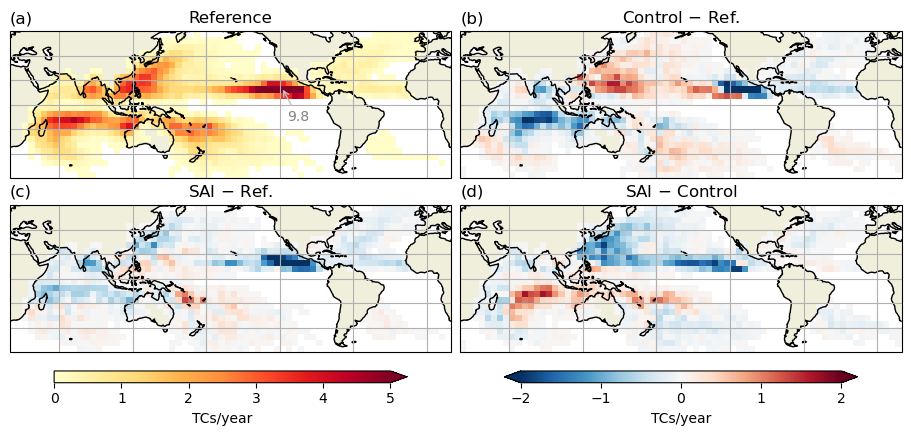

In [40]:
fname = 'track_density_seeds_succes_4panel.pdf'
kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False)
cbkwargs = dict(orientation='horizontal', aspect=30, shrink=0.8)
titles = {
    '(a)': 'Reference',
    '(b)': 'Control $-$ Ref.',
    '(c)': 'SAI $-$ Ref.',
    '(d)': 'SAI $-$ Control',
}
vlims = {'ref':{'vmin':0, 'vmax':5}, 'diff':{'vmin':-2,'vmax':2}}

def annotate_minmax(ax, xytext, data, method='max'):
    if method == 'min':
        xtr = data.isel(data.argmin(...))
    elif method == 'max':
        xtr = data.isel(data.argmax(...))
    ax.annotate(xy=(xtr.xbins,xtr.ybins), text=f"{xtr:.1f}", c='grey', size=10, va='center', ha='center', xytext=(255,-10), 
            transform=ccrs.PlateCarree(), arrowprops=dict(arrowstyle="->",shrinkB=0,ec='silver'))
    return

fig, axs = plt.subplots(2,2, figsize=(9,4.2), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

ax = axs[0,0] # ref. track density
cfdata = hists_s['Reference']#.hcount.mean('x')
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)
#annotate_minmax(ax, (255,-10), cfdata, method='max')
#ax.scatter(mx.xbins, mx.ybins, c='r', s=1, transform=ccrs.PlateCarree())

ax = axs[0,1] # RCP-Ref track density
exps = 'RCP8.5-Reference'
cfdata = hists_s[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
#mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
#x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
#si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
#annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[1,0] # SAI-Ref track density
exps = 'SAI2050-Reference'
cfdata = hists_s[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
#mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
#x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
#si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
#annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[1,1] # SAI-RCP track density
exps = 'SAI2050-RCP8.5'
cfdata = hists_s[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
#mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
#x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=2, marker='x', linewidths=0.3, c='k', edgecolors='none', transform=ccrs.PlateCarree())
#si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

for ax,(lab,title) in zip(axs.flatten(), titles.items()):
    ax.gridlines()
    ax.coastlines()
    #ax.stock_img()
    ax.add_feature(cfeature.LAND)
    ax.set_title(title)
    ax.set_title(lab, loc='left')
    ax.set_extent((0,360,-60,60), crs=ccrs.PlateCarree())

cb = fig.colorbar(cf, ax=axs[:,1], extend='both', **cbkwargs)
cb.ax.set_xlabel('TCs/year')
cb = fig.colorbar(cf_ref, ax=axs[:,0], extend='max', **cbkwargs)
cb.ax.set_xlabel('TCs/year')

#tracks.savefig(fig, fname, **savefigkwargs)

Text(0.5, 0, 'TCs/year')

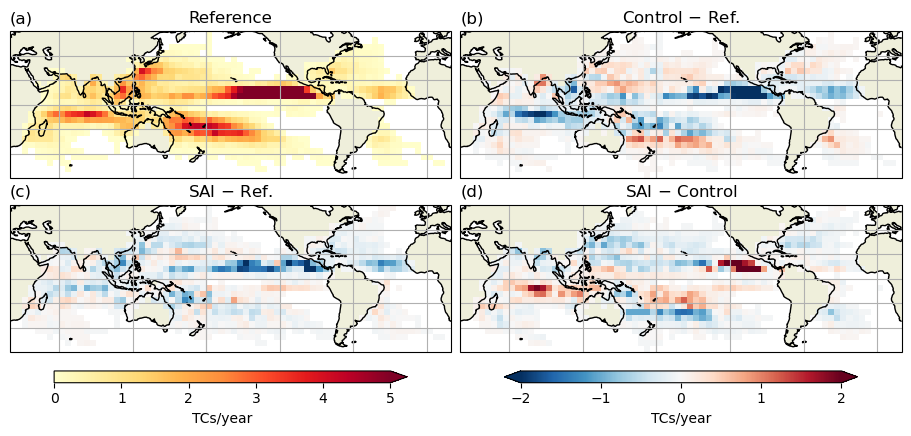

In [41]:
fname = 'track_density_seeds_fail_4panel.pdf'
kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False)
cbkwargs = dict(orientation='horizontal', aspect=30, shrink=0.8)
titles = {
    '(a)': 'Reference',
    '(b)': 'Control $-$ Ref.',
    '(c)': 'SAI $-$ Ref.',
    '(d)': 'SAI $-$ Control',
}
vlims = {'ref':{'vmin':0, 'vmax':5}, 'diff':{'vmin':-2,'vmax':2}}

def annotate_minmax(ax, xytext, data, method='max'):
    if method == 'min':
        xtr = data.isel(data.argmin(...))
    elif method == 'max':
        xtr = data.isel(data.argmax(...))
    ax.annotate(xy=(xtr.xbins,xtr.ybins), text=f"{xtr:.1f}", c='grey', size=10, va='center', ha='center', xytext=(255,-10), 
            transform=ccrs.PlateCarree(), arrowprops=dict(arrowstyle="->",shrinkB=0,ec='silver'))
    return

fig, axs = plt.subplots(2,2, figsize=(9,4.2), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

ax = axs[0,0] # ref. track density
cfdata = hists_f['Reference']#.hcount.mean('x')
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)
#annotate_minmax(ax, (255,-10), cfdata, method='max')
#ax.scatter(mx.xbins, mx.ybins, c='r', s=1, transform=ccrs.PlateCarree())

ax = axs[0,1] # RCP-Ref track density
exps = 'RCP8.5-Reference'
cfdata = hists_f[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
#mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
#x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
#si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
#annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[1,0] # SAI-Ref track density
exps = 'SAI2050-Reference'
cfdata = hists_f[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
#mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
#x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
#si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
#annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[1,1] # SAI-RCP track density
exps = 'SAI2050-RCP8.5'
cfdata = hists_f[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
#mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
#x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=2, marker='x', linewidths=0.3, c='k', edgecolors='none', transform=ccrs.PlateCarree())
#si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

for ax,(lab,title) in zip(axs.flatten(), titles.items()):
    ax.gridlines()
    ax.coastlines()
    #ax.stock_img()
    ax.add_feature(cfeature.LAND)
    ax.set_title(title)
    ax.set_title(lab, loc='left')
    ax.set_extent((0,360,-60,60), crs=ccrs.PlateCarree())

cb = fig.colorbar(cf, ax=axs[:,1], extend='both', **cbkwargs)
cb.ax.set_xlabel('TCs/year')
cb = fig.colorbar(cf_ref, ax=axs[:,0], extend='max', **cbkwargs)
cb.ax.set_xlabel('TCs/year')

#tracks.savefig(fig, fname, **savefigkwargs)

### plot initial 48 hours of tracks

In [20]:
%%time
xbins=np.arange(0, 361, 5)
ybins=np.arange(-90, 91, 5)

hists_s = {exp: (tracks.track_density(ds_sd_s[exp].isel(dtime=slice(0,16)), xbins=xbins, ybins=ybins).hcount
               .stack(x=['ens','year'])) for exp in ds_sd_s}
hists_f = {exp: (tracks.track_density(ds_sd_f[exp].isel(dtime=slice(0,16)), xbins=xbins, ybins=ybins).hcount
               .stack(x=['ens','year'])) for exp in ds_sd_f}
#stderr = {exp: tracks.stderr(hists[exp], dim='x') for exp in ds}

for exp in ['RCP8.5-Reference','SAI2050-Reference','SAI2050-RCP8.5']:
    exp1,exp2 = exp.split('-')
    hists_s[exp] = hists_s[exp1].mean('x') - hists_s[exp2].mean('x')
    hists_f[exp] = hists_f[exp1].mean('x') - hists_f[exp2].mean('x')
    histsum_s = hists_s[exp1].mean('x') + hists_s[exp2].mean('x')
    histsum_f = hists_f[exp1].mean('x') + hists_f[exp2].mean('x')
    hists_s[exp] = hists_s[exp].where(histsum_s!=0)
    hists_f[exp] = hists_f[exp].where(histsum_f!=0)
    #stderr[exp] = tracks.stderr(hists[exp1], hists[exp2], dim='x')
for exp in ds_sd_s:
    hists_s[exp] = hists_s[exp].mean('x', keep_attrs=True)
    hists_f[exp] = hists_f[exp].mean('x', keep_attrs=True)
    hists_s[exp] = hists_s[exp].where(hists_s[exp]!=0)
    hists_f[exp] = hists_f[exp].where(hists_f[exp]!=0)

CPU times: user 30.5 s, sys: 122 ms, total: 30.7 s
Wall time: 31.3 s


Text(0.5, 0, 'TCs/year')

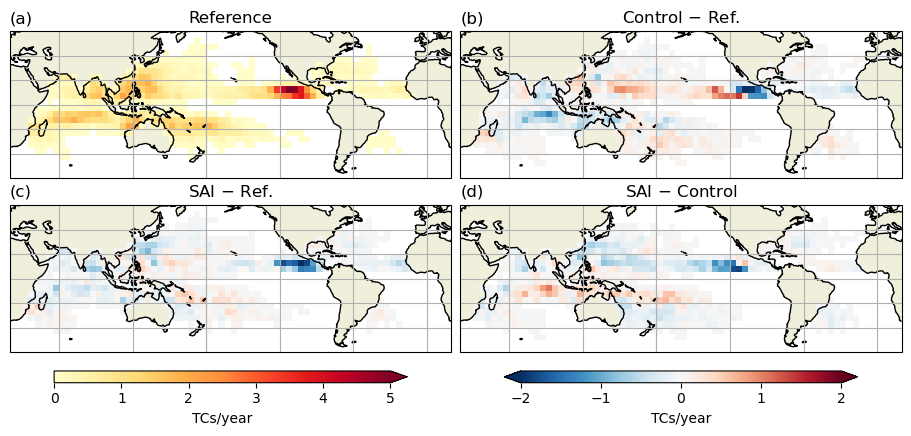

In [21]:
fname = 'track_density_seeds_succes_48hr_4panel.pdf'
kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False)
cbkwargs = dict(orientation='horizontal', aspect=30, shrink=0.8)
titles = {
    '(a)': 'Reference',
    '(b)': 'Control $-$ Ref.',
    '(c)': 'SAI $-$ Ref.',
    '(d)': 'SAI $-$ Control',
}
vlims = {'ref':{'vmin':0, 'vmax':5}, 'diff':{'vmin':-2,'vmax':2}}

def annotate_minmax(ax, xytext, data, method='max'):
    if method == 'min':
        xtr = data.isel(data.argmin(...))
    elif method == 'max':
        xtr = data.isel(data.argmax(...))
    ax.annotate(xy=(xtr.xbins,xtr.ybins), text=f"{xtr:.1f}", c='grey', size=10, va='center', ha='center', xytext=(255,-10), 
            transform=ccrs.PlateCarree(), arrowprops=dict(arrowstyle="->",shrinkB=0,ec='silver'))
    return

fig, axs = plt.subplots(2,2, figsize=(9,4.2), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

ax = axs[0,0] # ref. track density
cfdata = hists_s['Reference']#.hcount.mean('x')
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)
#annotate_minmax(ax, (255,-10), cfdata, method='max')
#ax.scatter(mx.xbins, mx.ybins, c='r', s=1, transform=ccrs.PlateCarree())

ax = axs[0,1] # RCP-Ref track density
exps = 'RCP8.5-Reference'
cfdata = hists_s[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
#mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
#x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
#si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
#annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[1,0] # SAI-Ref track density
exps = 'SAI2050-Reference'
cfdata = hists_s[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
#mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
#x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
#si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
#annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[1,1] # SAI-RCP track density
exps = 'SAI2050-RCP8.5'
cfdata = hists_s[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
#mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
#x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=2, marker='x', linewidths=0.3, c='k', edgecolors='none', transform=ccrs.PlateCarree())
#si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

for ax,(lab,title) in zip(axs.flatten(), titles.items()):
    ax.gridlines()
    ax.coastlines()
    #ax.stock_img()
    ax.add_feature(cfeature.LAND)
    ax.set_title(title)
    ax.set_title(lab, loc='left')
    ax.set_extent((0,360,-60,60), crs=ccrs.PlateCarree())

cb = fig.colorbar(cf, ax=axs[:,1], extend='both', **cbkwargs)
cb.ax.set_xlabel('TCs/year')
cb = fig.colorbar(cf_ref, ax=axs[:,0], extend='max', **cbkwargs)
cb.ax.set_xlabel('TCs/year')

#tracks.savefig(fig, fname, **savefigkwargs)

Text(0.5, 0, 'TCs/year')

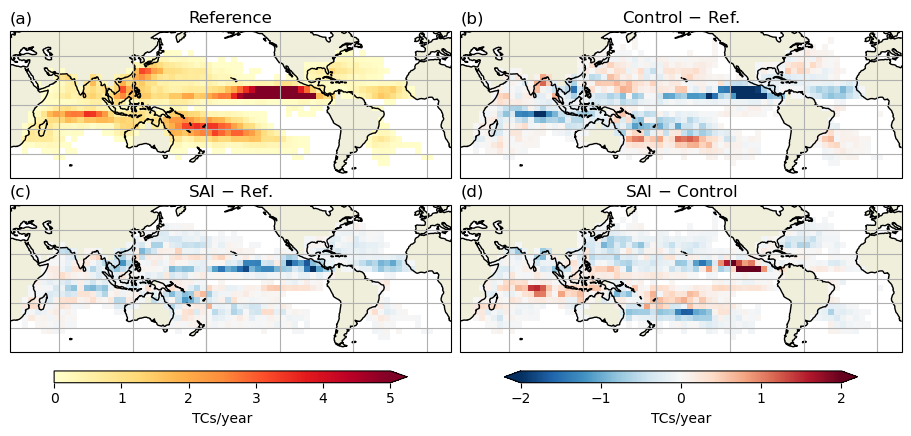

In [22]:
fname = 'track_density_seeds_fail_48hr_4panel.pdf'
kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False)
cbkwargs = dict(orientation='horizontal', aspect=30, shrink=0.8)
titles = {
    '(a)': 'Reference',
    '(b)': 'Control $-$ Ref.',
    '(c)': 'SAI $-$ Ref.',
    '(d)': 'SAI $-$ Control',
}
vlims = {'ref':{'vmin':0, 'vmax':5}, 'diff':{'vmin':-2,'vmax':2}}

def annotate_minmax(ax, xytext, data, method='max'):
    if method == 'min':
        xtr = data.isel(data.argmin(...))
    elif method == 'max':
        xtr = data.isel(data.argmax(...))
    ax.annotate(xy=(xtr.xbins,xtr.ybins), text=f"{xtr:.1f}", c='grey', size=10, va='center', ha='center', xytext=(255,-10), 
            transform=ccrs.PlateCarree(), arrowprops=dict(arrowstyle="->",shrinkB=0,ec='silver'))
    return

fig, axs = plt.subplots(2,2, figsize=(9,4.2), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

ax = axs[0,0] # ref. track density
cfdata = hists_f['Reference']#.hcount.mean('x')
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)
#annotate_minmax(ax, (255,-10), cfdata, method='max')
#ax.scatter(mx.xbins, mx.ybins, c='r', s=1, transform=ccrs.PlateCarree())

ax = axs[0,1] # RCP-Ref track density
exps = 'RCP8.5-Reference'
cfdata = hists_f[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
#mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
#x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
#si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
#annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[1,0] # SAI-Ref track density
exps = 'SAI2050-Reference'
cfdata = hists_f[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
#mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
#x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
#si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
#annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[1,1] # SAI-RCP track density
exps = 'SAI2050-RCP8.5'
cfdata = hists_f[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
#mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
#x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=2, marker='x', linewidths=0.3, c='k', edgecolors='none', transform=ccrs.PlateCarree())
#si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

for ax,(lab,title) in zip(axs.flatten(), titles.items()):
    ax.gridlines()
    ax.coastlines()
    #ax.stock_img()
    ax.add_feature(cfeature.LAND)
    ax.set_title(title)
    ax.set_title(lab, loc='left')
    ax.set_extent((0,360,-60,60), crs=ccrs.PlateCarree())

cb = fig.colorbar(cf, ax=axs[:,1], extend='both', **cbkwargs)
cb.ax.set_xlabel('TCs/year')
cb = fig.colorbar(cf_ref, ax=axs[:,0], extend='max', **cbkwargs)
cb.ax.set_xlabel('TCs/year')

#tracks.savefig(fig, fname, **savefigkwargs)

### Genesis transition probability

In [27]:
%%time
xbins=np.arange(0, 361, 10)
ybins=np.arange(-90, 91, 7.5)

hists_s = {exp: (tracks.track_density(ds_sd_s[exp].isel(dtime=0), xbins=xbins, ybins=ybins).hcount
               .stack(x=['ens','year'])) for exp in ds_sd_s}
hists_f = {exp: (tracks.track_density(ds_sd_f[exp].isel(dtime=0), xbins=xbins, ybins=ybins).hcount
               .stack(x=['ens','year'])) for exp in ds_sd_f}
#stderr = {exp: tracks.stderr(hists[exp], dim='x') for exp in ds}

for exp in ['RCP8.5-Reference','SAI2050-Reference','SAI2050-RCP8.5']:
    exp1,exp2 = exp.split('-')
    hists_s[exp] = hists_s[exp1].mean('x') - hists_s[exp2].mean('x')
    hists_f[exp] = hists_f[exp1].mean('x') - hists_f[exp2].mean('x')
    histsum_s = hists_s[exp1].mean('x') + hists_s[exp2].mean('x')
    histsum_f = hists_f[exp1].mean('x') + hists_f[exp2].mean('x')
    hists_s[exp] = hists_s[exp].where(histsum_s!=0)
    hists_f[exp] = hists_f[exp].where(histsum_f!=0)
    #stderr[exp] = tracks.stderr(hists[exp1], hists[exp2], dim='x')
for exp in ds_sd_s:
    hists_s[exp] = hists_s[exp].mean('x', keep_attrs=True)
    hists_f[exp] = hists_f[exp].mean('x', keep_attrs=True)
    hists_s[exp] = hists_s[exp].where(hists_s[exp]!=0)
    hists_f[exp] = hists_f[exp].where(hists_f[exp]!=0)

CPU times: user 2.16 s, sys: 3.03 ms, total: 2.16 s
Wall time: 2.19 s


In [28]:
# transition probability!
hists = {exp: (hists_s[exp] / (hists_s[exp] + hists_f[exp])).where(hists_s[exp]>=0.0) for exp in hists_s}

for exp in ['RCP8.5-Reference','SAI2050-Reference','SAI2050-RCP8.5']:
    exp1,exp2 = exp.split('-')
    hists[exp] = hists[exp1] - hists[exp2]
    #histsum = hists[exp1].mean('x') + hists[exp2].mean('x')
    #hists[exp] = hists[exp].where(histsum!=0)
   
    #stderr[exp] = tracks.stderr(hists[exp1], hists[exp2], dim='x')
#for exp in ds_sd_s:
#    hists[exp] = hists[exp].mean('x', keep_attrs=True)
#    hists[exp] = hists[exp].where(hists[exp]!=0)

Text(0.5, 0, 'TCs/year')

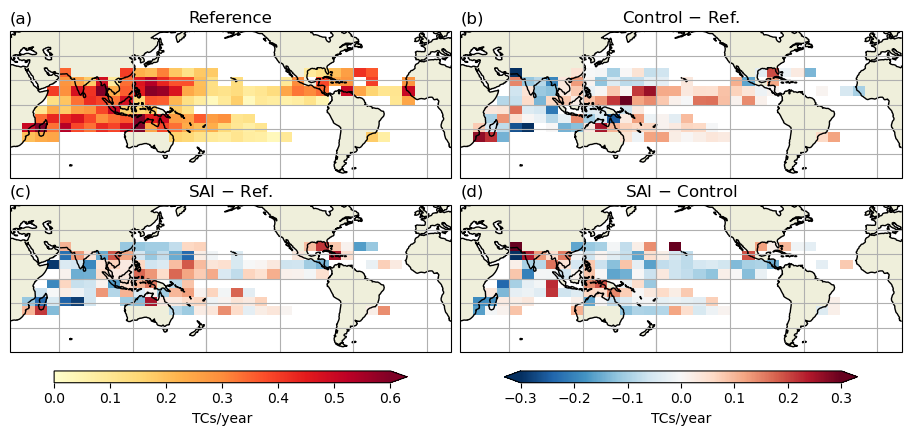

In [29]:
fname = 'track_density_seeds_transprob_48hr_4panel.pdf'
kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False)
cbkwargs = dict(orientation='horizontal', aspect=30, shrink=0.8)
titles = {
    '(a)': 'Reference',
    '(b)': 'Control $-$ Ref.',
    '(c)': 'SAI $-$ Ref.',
    '(d)': 'SAI $-$ Control',
}
vlims = {'ref':{'vmin':0, 'vmax':.6}, 'diff':{'vmin':-.3,'vmax':.3}}

def annotate_minmax(ax, xytext, data, method='max'):
    if method == 'min':
        xtr = data.isel(data.argmin(...))
    elif method == 'max':
        xtr = data.isel(data.argmax(...))
    ax.annotate(xy=(xtr.xbins,xtr.ybins), text=f"{xtr:.1f}", c='grey', size=10, va='center', ha='center', xytext=(255,-10), 
            transform=ccrs.PlateCarree(), arrowprops=dict(arrowstyle="->",shrinkB=0,ec='silver'))
    return

fig, axs = plt.subplots(2,2, figsize=(9,4.2), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

ax = axs[0,0] # ref. track density
cfdata = hists['Reference']#.hcount.mean('x')
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)
#annotate_minmax(ax, (255,-10), cfdata, method='max')
#ax.scatter(mx.xbins, mx.ybins, c='r', s=1, transform=ccrs.PlateCarree())

ax = axs[0,1] # RCP-Ref track density
exps = 'RCP8.5-Reference'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
#mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
#x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
#si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
#annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[1,0] # SAI-Ref track density
exps = 'SAI2050-Reference'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
#mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
#x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
#si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
#annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[1,1] # SAI-RCP track density
exps = 'SAI2050-RCP8.5'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
#mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
#x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=2, marker='x', linewidths=0.3, c='k', edgecolors='none', transform=ccrs.PlateCarree())
#si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

for ax,(lab,title) in zip(axs.flatten(), titles.items()):
    ax.gridlines()
    ax.coastlines()
    #ax.stock_img()
    ax.add_feature(cfeature.LAND)
    ax.set_title(title)
    ax.set_title(lab, loc='left')
    ax.set_extent((0,360,-60,60), crs=ccrs.PlateCarree())

cb = fig.colorbar(cf, ax=axs[:,1], extend='both', **cbkwargs)
cb.ax.set_xlabel('TCs/year')
cb = fig.colorbar(cf_ref, ax=axs[:,0], extend='max', **cbkwargs)
cb.ax.set_xlabel('TCs/year')

#tracks.savefig(fig, fname, **savefigkwargs)

### transition probability after 24 hours

In [54]:
%%time
xbins=np.arange(0, 361, 15)
ybins=np.arange(-90, 91, 10)

hists_s = {exp: (tracks.track_density(ds_sd_s[exp].isel(dtime=8), xbins=xbins, ybins=ybins).hcount
               .stack(x=['ens','year'])) for exp in ds_sd_s}
hists_f = {exp: (tracks.track_density(ds_sd_f[exp].isel(dtime=8), xbins=xbins, ybins=ybins).hcount
               .stack(x=['ens','year'])) for exp in ds_sd_f}
#stderr = {exp: tracks.stderr(hists[exp], dim='x') for exp in ds}

for exp in ['RCP8.5-Reference','SAI2050-Reference','SAI2050-RCP8.5']:
    exp1,exp2 = exp.split('-')
    hists_s[exp] = hists_s[exp1].mean('x') - hists_s[exp2].mean('x')
    hists_f[exp] = hists_f[exp1].mean('x') - hists_f[exp2].mean('x')
    histsum_s = hists_s[exp1].mean('x') + hists_s[exp2].mean('x')
    histsum_f = hists_f[exp1].mean('x') + hists_f[exp2].mean('x')
    hists_s[exp] = hists_s[exp].where(histsum_s!=0)
    hists_f[exp] = hists_f[exp].where(histsum_f!=0)
    #stderr[exp] = tracks.stderr(hists[exp1], hists[exp2], dim='x')
for exp in ds_sd_s:
    hists_s[exp] = hists_s[exp].mean('x', keep_attrs=True)
    hists_f[exp] = hists_f[exp].mean('x', keep_attrs=True)
    hists_s[exp] = hists_s[exp].where(hists_s[exp]!=0)
    hists_f[exp] = hists_f[exp].where(hists_f[exp]!=0)

CPU times: user 2 s, sys: 22.1 ms, total: 2.03 s
Wall time: 2.05 s


In [61]:
# transition probability!
hists = {exp: (hists_s[exp] * 100 / (hists_s[exp] + hists_f[exp])).where((hists_s[exp]>0.0) & (hists_f[exp]>0.0)) for exp in hists_s}

for exp in ['RCP8.5-Reference','SAI2050-Reference','SAI2050-RCP8.5']:
    exp1,exp2 = exp.split('-')
    hists[exp] = hists[exp1] - hists[exp2]
    #histsum = hists[exp1].mean('x') + hists[exp2].mean('x')
    #hists[exp] = hists[exp].where(histsum!=0)
   
    #stderr[exp] = tracks.stderr(hists[exp1], hists[exp2], dim='x')
#for exp in ds_sd_s:
#    hists[exp] = hists[exp].mean('x', keep_attrs=True)
#    hists[exp] = hists[exp].where(hists[exp]!=0)

saving ../figures/track_density_seeds_transprob_24hr_4panel.pdf...


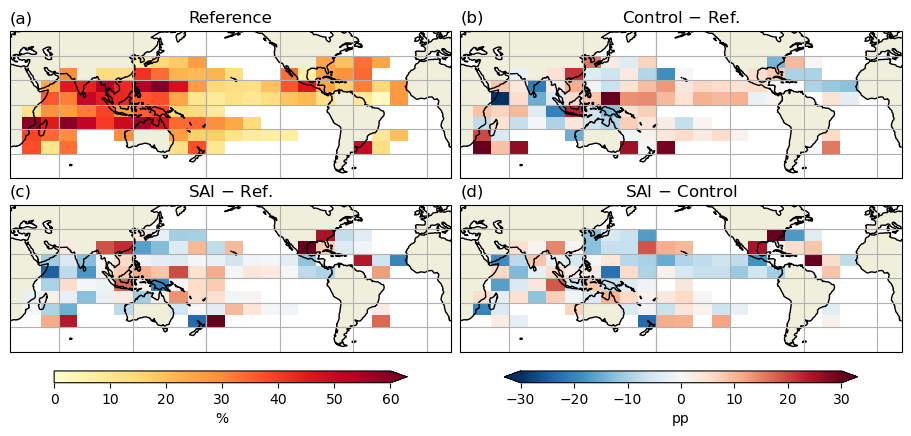

In [65]:
fname = 'track_density_seeds_transprob_24hr_4panel.pdf'
kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False)
cbkwargs = dict(orientation='horizontal', aspect=30, shrink=0.8)
titles = {
    '(a)': 'Reference',
    '(b)': 'Control $-$ Ref.',
    '(c)': 'SAI $-$ Ref.',
    '(d)': 'SAI $-$ Control',
}
vlims = {'ref':{'vmin':0, 'vmax':60}, 'diff':{'vmin':-30,'vmax':30}}

def annotate_minmax(ax, xytext, data, method='max'):
    if method == 'min':
        xtr = data.isel(data.argmin(...))
    elif method == 'max':
        xtr = data.isel(data.argmax(...))
    ax.annotate(xy=(xtr.xbins,xtr.ybins), text=f"{xtr:.1f}", c='grey', size=10, va='center', ha='center', xytext=(255,-10), 
            transform=ccrs.PlateCarree(), arrowprops=dict(arrowstyle="->",shrinkB=0,ec='silver'))
    return

fig, axs = plt.subplots(2,2, figsize=(9,4.2), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

ax = axs[0,0] # ref. track density
cfdata = hists['Reference']#.hcount.mean('x')
cf_ref = cfdata.plot(ax=ax, **vlims['ref'], cmap='YlOrRd', **kwargs)
#annotate_minmax(ax, (255,-10), cfdata, method='max')
#ax.scatter(mx.xbins, mx.ybins, c='r', s=1, transform=ccrs.PlateCarree())

ax = axs[0,1] # RCP-Ref track density
exps = 'RCP8.5-Reference'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
#mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
#x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
#si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
#annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[1,0] # SAI-Ref track density
exps = 'SAI2050-Reference'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
#mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
#x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())
#si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())
#annotate_minmax(ax, (255,-10), cfdata, method='min')

ax = axs[1,1] # SAI-RCP track density
exps = 'SAI2050-RCP8.5'
cfdata = hists[exps]
cf = cfdata.plot(ax=ax, **vlims['diff'], cmap='RdBu_r', **kwargs)
# sig = np.sqrt(stderr[exps[0]]**2+stderr[exps[1]]**2)/np.sqrt(2)
#mask = xr.where(np.abs(cfdata) < (Zsig*stderr[exps]), True, False).transpose('xbins','ybins')
#x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
#si = ax.scatter(x[mask], y[mask], s=2, marker='x', linewidths=0.3, c='k', edgecolors='none', transform=ccrs.PlateCarree())
#si = ax.contourf(x, y, mask, hatches=['','///'], alpha=0, transform=ccrs.PlateCarree())

for ax,(lab,title) in zip(axs.flatten(), titles.items()):
    ax.gridlines()
    ax.coastlines()
    #ax.stock_img()
    ax.add_feature(cfeature.LAND)
    ax.set_title(title)
    ax.set_title(lab, loc='left')
    ax.set_extent((0,360,-60,60), crs=ccrs.PlateCarree())

cb = fig.colorbar(cf, ax=axs[:,1], extend='both', **cbkwargs)
cb.ax.set_xlabel('pp')
cb = fig.colorbar(cf_ref, ax=axs[:,0], extend='max', **cbkwargs)
cb.ax.set_xlabel('%')

tracks.savefig(fig, fname, **savefigkwargs)

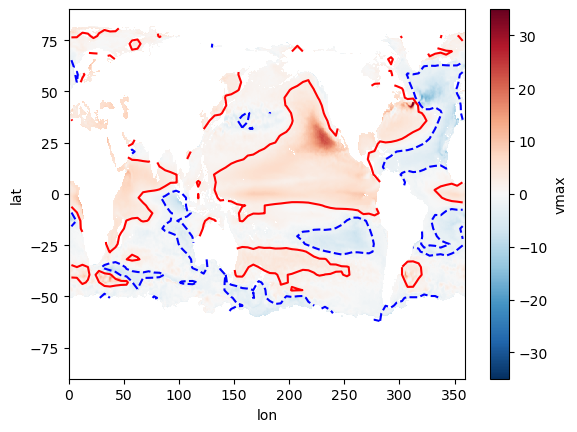

In [126]:
dsPI = xr.open_dataset('../jobs/PI/data/PI.nc')
dsPI['dpm'] = ('month', [31,28,31,30,31,30,31,31,30,31,30,31])
dvmax_NH = (dsPI.vmax.sel(month=MONTHS_NH, exp='cnt') - dsPI.vmax.sel(month=MONTHS_NH, exp='ref')).weighted(dsPI.dpm).mean('month')
dvmax_SH = (dsPI.vmax.sel(month=MONTHS_SH, exp='cnt') - dsPI.vmax.sel(month=MONTHS_SH, exp='ref')).weighted(dsPI.dpm).mean('month')
dvmax_NH.plot()
dvmax_NH.coarsen(lat=8,lon=8).mean().plot.contour(levels=[-2,2], colors=['b','r'])

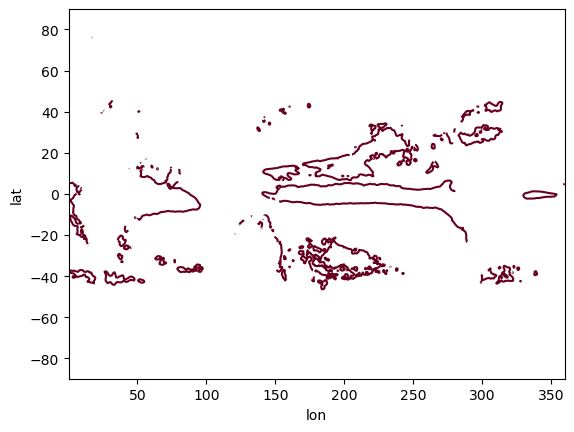

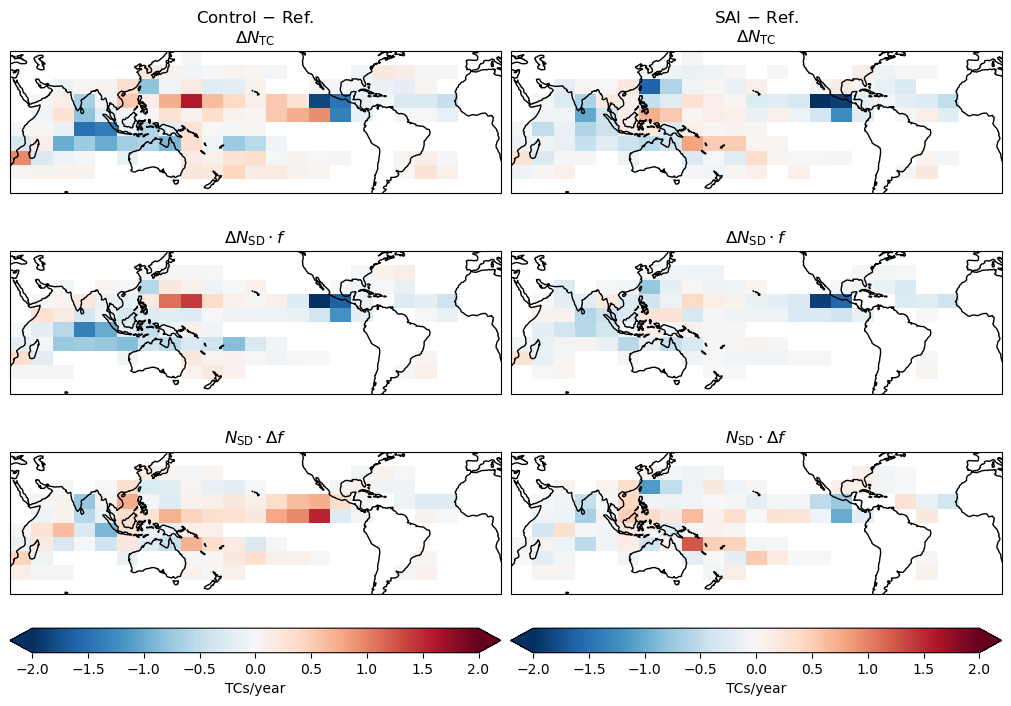

In [129]:
fig, axs = plt.subplots(3,2,figsize=(10,7), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

vmin = -2
vmax = 2
cmap = 'RdBu_r'

nseed = hists_s['Reference'] + hists_f['Reference']
frac = hists_s['Reference'] / nseed

exp = 'RCP8.5-Reference'
dtc = hists_s[exp]
nseed2 = hists_s['RCP8.5'] + hists_f['RCP8.5']
dnseed = nseed2 - nseed
frac2 = hists_s['RCP8.5'] / nseed2
dfrac = frac2 - frac


ax = axs[0,0]
hp1 = dtc.plot(ax=ax, transform=ccrs.PlateCarree(), ylim=[-50,50], extend='both', vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)
#dvmax_NH.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[20], colors='r')
#dvmax_NH.coarsen(lat=8,lon=8).mean().plot.contour(levels=[-2,2], ax=ax, transform=ccrs.PlateCarree(), colors=['b','r'])
ax.set_title(r'Control $-$ Ref.'+'\n'+r'$\Delta N_{\text{TC}}$')

ax = axs[1,0]
hp2 = (dnseed*frac).plot(ax=ax, transform=ccrs.PlateCarree(), ylim=[-50,50], extend='both', vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)
ax.set_title(r'$\Delta N_{\text{SD}} \cdot f$')

ax = axs[2,0]
hp3 = (nseed*dfrac).plot(ax=ax, transform=ccrs.PlateCarree(), ylim=[-50,50], extend='both', vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)
ax.set_title(r'$N_{\text{SD}} \cdot \Delta f$')

exp = 'SAI2050-Reference'
dtc = hists_s[exp]
nseed2 = hists_s['SAI2050'] + hists_f['SAI2050']
dnseed = nseed2 - nseed
frac2 = hists_s['SAI2050'] / nseed2
dfrac = frac2 - frac

ax = axs[0,1]
hp4 = hists_s[exp].plot(ax=ax, transform=ccrs.PlateCarree(), ylim=[-50,50], extend='both', vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)
ax.set_title(r'SAI $-$ Ref.'+'\n'+r'$\Delta N_{\text{TC}}$')

ax = axs[1,1]
hp5 = (dnseed*frac).plot(ax=ax, transform=ccrs.PlateCarree(), ylim=[-50,50], extend='both', vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)
ax.set_title(r'$\Delta N_{\text{SD}} \cdot f$')

ax = axs[2,1]
hp6 = (nseed*dfrac).plot(ax=ax, transform=ccrs.PlateCarree(), ylim=[-50,50], extend='both', vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)
ax.set_title(r'$N_{\text{SD}} \cdot \Delta f$')

#cb1 = fig.colorbar(hp1, ax=axs[0,0], orientation='horizontal')
#cb1.ax.set_xlabel('TCs/year')
cb2 = fig.colorbar(hp2, ax=axs[:,0], extend='both',  orientation='horizontal')
cb2.ax.set_xlabel('TCs/year')
#cb3 = fig.colorbar(hp4, ax=axs[0,1], orientation='horizontal')
#cb3.ax.set_xlabel('TCs/year')
cb4 = fig.colorbar(hp5, ax=axs[:,1], extend='both', orientation='horizontal')
cb4.ax.set_xlabel('TCs/year')

for ax in axs.flat:
    ax.coastlines()

fig.savefig('../figures/synthesis_figure.pdf', transparent=True, bbox_inches='tight')

(0.0, 6.0)

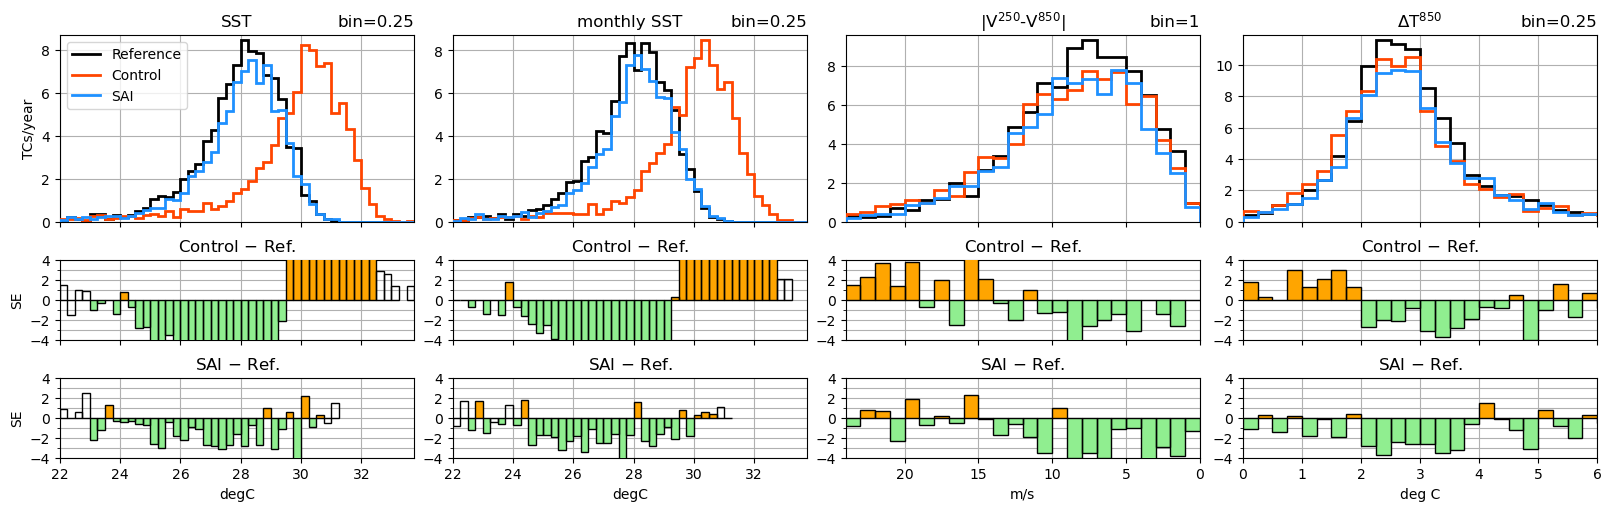

In [38]:
default_kwargs = {  # default line plot kwargs
    'Reference': dict(color='black', lw=2, label='Reference'),
    'RCP8.5': dict(color='orangered', lw=2, label='Control'), 
    'SAI2050': dict(color='dodgerblue', lw=2, label='SAI'),
    'RCP8.5-Reference': dict(color='red', lw=2, label='Control $-$ Ref.'), 
    'SAI2050-Reference': dict(color='green', lw=2, label='SAI $-$ Ref.'),
    'SAI2050-RCP8.5': dict(color='blue', lw=2, label='SAI $-$ Control'),
}

hist_kwargs = {
    'lon': {'bins': np.arange(0,361,10), 'title': 'longitude', 'rev':False},
    'lat': {'bins': np.arange(-45,45.1,2.5), 'title': 'latitude', 'rev':False},
    'PSL': {'bins': np.arange(900,1015,2.5), 'title': r'PSL$_{\mathrm{min}}$', 'rev':True},
    'PSLmon': {'bins': np.arange(995,1025,1), 'title': r'PSL$_{\mathrm{monthly}}$', 'rev':True},
    'U10': {'bins': np.arange(10,60,1), 'title': r'V$^{10}_{\mathrm{max}}$', 'rev':False},
    'RMW': {'bins': np.arange(20,150,5), 'title': r'RMW$^{10}$', 'rev':True}, 
    'SST': {'bins': np.arange(22,34,0.25), 'title': 'SST', 'rev':False},
    'SSTmon': {'bins': np.arange(22,34,0.25), 'title': 'monthly SST', 'rev':False},
    'RV': {'bins': np.arange(4e-4,4e-3,1e-4), 'title': r'RV$^{850}$', 'rev':False},
    'Vshear': {'bins': np.arange(0,25,1), 'title': r'|V$^{250}$-V$^{850}$|', 'rev':True},
    'PRECT':{'bins': np.arange(0,76,2.5), 'title': r'PREC$_{\mathrm{max}}$', 'rev':False},
    'TEMP': {'bins': np.arange(0,10,0.25), 'title': r'$\Delta$T$^{850}$', 'rev':False},
}

yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
ytag = 'SE' if yunits=='SE' else 'TC'
method = 'maxRV'         # reduction method (passed to track_stat)
plot_vars = ['SST','SSTmon','Vshear','TEMP'] # list of variables to plot, one for each column
exps = [list(ds_sd_s), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)
fname = f"hist_{method}_{ytag}_{'_'.join(plot_vars)}.pdf"

fig,axs = plt.subplots(3,len(plot_vars), height_ratios=(7,3,3), figsize=(len(plot_vars)*4,5), 
    sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))
ds_max = {exp: tracks.track_stat(ds_sd_s[exp], method) for exp in ds_sd_s}
for col,var in enumerate(plot_vars):
    hists = {exp: tracks.histogram(ds_max[exp][var], hist_kwargs[var]['bins']) for exp in ds_max}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        tracks.plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(ds_max['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

axs[0,3].set_xlim([0,6])
#tracks.savefig(fig, fname, **savefigkwargs)

(0.0, 6.0)

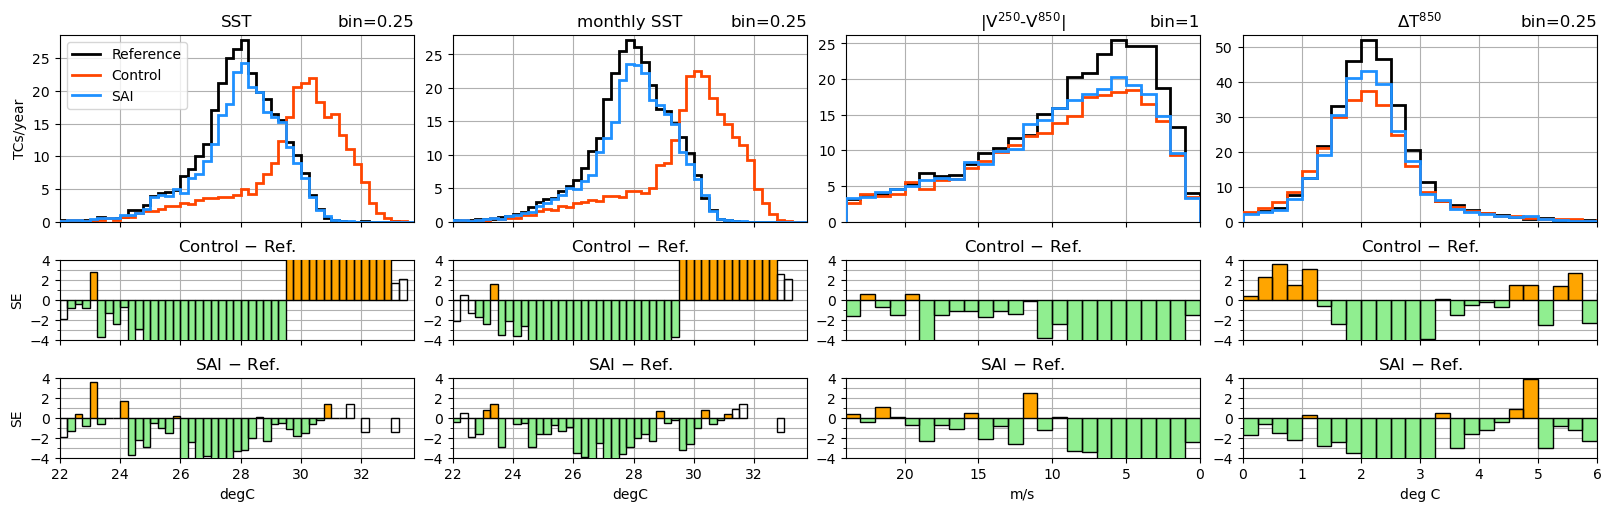

In [88]:
default_kwargs = {  # default line plot kwargs
    'Reference': dict(color='black', lw=2, label='Reference'),
    'RCP8.5': dict(color='orangered', lw=2, label='Control'), 
    'SAI2050': dict(color='dodgerblue', lw=2, label='SAI'),
    'RCP8.5-Reference': dict(color='red', lw=2, label='Control $-$ Ref.'), 
    'SAI2050-Reference': dict(color='green', lw=2, label='SAI $-$ Ref.'),
    'SAI2050-RCP8.5': dict(color='blue', lw=2, label='SAI $-$ Control'),
}

hist_kwargs = {
    'lon': {'bins': np.arange(0,361,10), 'title': 'longitude', 'rev':False},
    'lat': {'bins': np.arange(-45,45.1,2.5), 'title': 'latitude', 'rev':False},
    'PSL': {'bins': np.arange(900,1015,2.5), 'title': r'PSL$_{\mathrm{min}}$', 'rev':True},
    'PSLmon': {'bins': np.arange(995,1025,1), 'title': r'PSL$_{\mathrm{monthly}}$', 'rev':True},
    'U10': {'bins': np.arange(10,60,1), 'title': r'V$^{10}_{\mathrm{max}}$', 'rev':False},
    'RMW': {'bins': np.arange(20,150,5), 'title': r'RMW$^{10}$', 'rev':True}, 
    'SST': {'bins': np.arange(22,34,0.25), 'title': 'SST', 'rev':False},
    'SSTmon': {'bins': np.arange(22,34,0.25), 'title': 'monthly SST', 'rev':False},
    'RV': {'bins': np.arange(4e-4,4e-3,1e-4), 'title': r'RV$^{850}$', 'rev':False},
    'Vshear': {'bins': np.arange(0,25,1), 'title': r'|V$^{250}$-V$^{850}$|', 'rev':True},
    'PRECT':{'bins': np.arange(0,76,2.5), 'title': r'PREC$_{\mathrm{max}}$', 'rev':False},
    'TEMP': {'bins': np.arange(0,10,0.25), 'title': r'$\Delta$T$^{850}$', 'rev':False},
}

yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
ytag = 'SE' if yunits=='SE' else 'TC'
method = 'maxRV'         # reduction method (passed to track_stat)
plot_vars = ['SST','SSTmon','Vshear','TEMP'] # list of variables to plot, one for each column
exps = [list(ds_sd_f), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)
fname = f"hist_{method}_{ytag}_{'_'.join(plot_vars)}.pdf"

fig,axs = plt.subplots(3,len(plot_vars), height_ratios=(7,3,3), figsize=(len(plot_vars)*4,5), 
    sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))
ds_max = {exp: tracks.track_stat(ds_sd_f[exp], method) for exp in ds_sd_f}
for col,var in enumerate(plot_vars):
    hists = {exp: tracks.histogram(ds_max[exp][var], hist_kwargs[var]['bins']) for exp in ds_max}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        tracks.plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(ds_max['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

axs[0,3].set_xlim([0,6])
#tracks.savefig(fig, fname, **savefigkwargs)

To Do:  
- seed track density success vs fail (initial 48 hours of tracks)
- map changes in succes rate
- plot monthly THTE850 - T100
- plot monthly RH 400-700 hPa

#### 16-02-2026 - Final testing of seeds
The seeds now have a minimum duration of 21 hours, to avoid showing too much daily disturbances. The optimum minimum duration seems to be 24 hours, which can be obtained by filtering the track data. The 21 hours was chosen to allow for some sensitivity testing (against minimum duration).

In [2]:
ds_tc = tracks.load_tracks('../../tracker/jobs/Tracking_TC_RV/', ext='')

REF.001: 5.000 years, 475 tracks
REF.002: 5.000 years, 484 tracks
REF.003: 5.000 years, 496 tracks
REF.004: 5.000 years, 500 tracks
REF.005: 5.000 years, 523 tracks
REF.006: 5.000 years, 462 tracks
RCP.001: 5.000 years, 445 tracks
RCP.002: 5.000 years, 437 tracks
RCP.003: 5.000 years, 459 tracks
RCP.004: 5.000 years, 464 tracks
RCP.005: 5.000 years, 455 tracks
RCP.006: 5.000 years, 473 tracks
SAI.001: 5.000 years, 425 tracks
SAI.002: 5.000 years, 430 tracks
SAI.003: 5.000 years, 412 tracks
SAI.004: 5.000 years, 430 tracks
SAI.005: 5.000 years, 406 tracks
SAI.006: 5.000 years, 421 tracks


In [4]:
ds_sd = tracks.load_tracks('../../tracker/jobs/Tracking_TC_RV.seeds2/', ext='.seeds2')

REF.001: 5.000 years, 2026 tracks
REF.002: 5.000 years, 2063 tracks
REF.003: 5.000 years, 2088 tracks
REF.004: 5.000 years, 2080 tracks
REF.005: 5.000 years, 2184 tracks
REF.006: 5.000 years, 2005 tracks
RCP.001: 5.000 years, 1854 tracks
RCP.002: 5.000 years, 1745 tracks
RCP.003: 5.000 years, 1698 tracks
RCP.004: 5.000 years, 1759 tracks
RCP.005: 5.000 years, 1808 tracks
RCP.006: 5.000 years, 1784 tracks
SAI.001: 5.000 years, 1697 tracks
SAI.002: 5.000 years, 1843 tracks
SAI.003: 5.000 years, 1795 tracks
SAI.004: 5.000 years, 1894 tracks
SAI.005: 5.000 years, 1783 tracks
SAI.006: 5.000 years, 1696 tracks


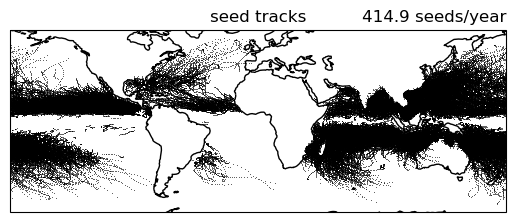

In [6]:
exp = 'Reference'
ax = plt.axes(projection=ccrs.PlateCarree())
ds_sd[exp].plot.scatter(ax=ax, x='lon', y='lat', c='k', edgecolors='k', linewidths=0.001, s=0.25, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('seed tracks')
_=ax.set_title(f'{ds_sd[exp].id.size/ds_sd[exp].num_days*365:.1f} seeds/year', loc='right')

Text(0.5, 1.0, 'seed tracks (initial 24 hours)')

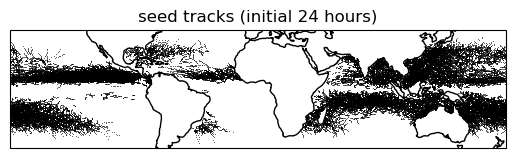

In [7]:
exp = 'Reference'
ax = plt.axes(projection=ccrs.PlateCarree())
ds_sd[exp].isel(dtime=range(0,8)).plot.scatter(ax=ax, x='lon', y='lat', c='k', edgecolors='k', linewidths=0.001, s=0.25, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('seed tracks (initial 24 hours)')

Text(0, 0.5, 'seeds/year')

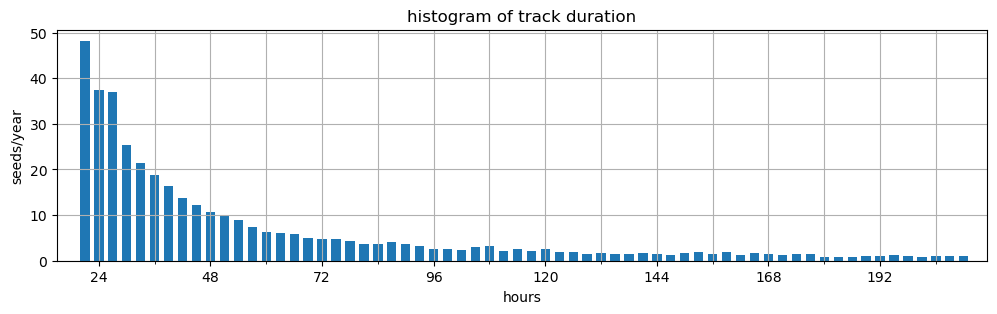

In [10]:
exp = 'Reference'
fig=plt.figure(figsize=(12,3))
ax = plt.axes()
track_size = ds_sd[exp].time.notnull().sum('dtime') * 3 # track duration [hours]
hist, bins = np.histogram(track_size, np.arange(-1.5,213,3))
ax.bar((bins[1:]+bins[:-1])/2, hist/ds_sd[exp].num_days.item()*365, width=2)
#track_size.plot.hist(ax=ax, bins=np.arange(0,9,0.25))
#_=plt.xticks(range(0,9,1))
ax.set_xticks(range(0,213,24))
ax.set_xticks(range(0,213,12), minor=True)
ax.set_xlim([15,215])
ax.grid(which='both')
ax.set_title('histogram of track duration')
ax.set_xlabel('hours')
ax.set_ylabel('seeds/year')

#### 13-02-25 - preliminary testing
The seeds are not cut off at 17 m/s anymore, with a minimum duration of 12 hours and run as long as new valid points are found (just as TCs). It seems like we can now match all TCs to a seed.

In [2]:
ds_tc = tracks.load_tracks('../../tracker/jobs/Tracking_TC_RV/', ext='')

REF.001: 5.000 years, 475 tracks
REF.002: 5.000 years, 484 tracks
REF.003: 5.000 years, 496 tracks
REF.004: 5.000 years, 500 tracks
REF.005: 5.000 years, 523 tracks
REF.006: 5.000 years, 462 tracks
RCP.001: 5.000 years, 445 tracks
RCP.002: 5.000 years, 437 tracks
RCP.003: 5.000 years, 459 tracks
RCP.004: 5.000 years, 464 tracks
RCP.005: 5.000 years, 455 tracks
RCP.006: 5.000 years, 473 tracks
SAI.001: 5.000 years, 425 tracks
SAI.002: 5.000 years, 430 tracks
SAI.003: 5.000 years, 412 tracks
SAI.004: 5.000 years, 430 tracks
SAI.005: 5.000 years, 406 tracks
SAI.006: 5.000 years, 421 tracks


In [3]:
#ds_sd = tracks.load_tracks('../../tracker/jobs/Tracking_TC_RV.seeds2/', ext='.seeds2')
ds_sd = tracks.load_track_file('../../tracker/jobs/Tracking_TC_RV.seeds2/TC_tracks.ref.001.seeds2.nc')
print(f"REF.001: {ds_sd.num_days/365:.3f} years, {ds_sd.id.size:d} tracks")

REF.001: 5.000 years, 3698 tracks


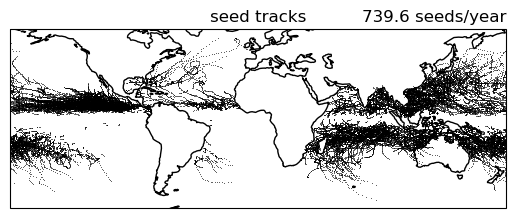

In [5]:
ax = plt.axes(projection=ccrs.PlateCarree())
ds_sd.plot.scatter(ax=ax, x='lon', y='lat', c='k', edgecolors='k', linewidths=0.001, s=0.25, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('seed tracks')
_=ax.set_title(f'{ds_sd.id.size/ds_sd.num_days*365:.1f} seeds/year', loc='right')

Text(0.5, 1.0, 'seed tracks (initial 24 hours)')

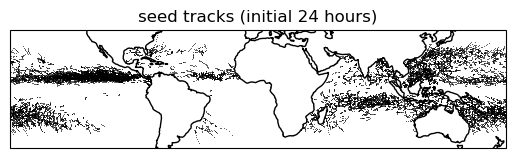

In [6]:
ax = plt.axes(projection=ccrs.PlateCarree())
ds_sd.isel(dtime=range(0,8)).plot.scatter(ax=ax, x='lon', y='lat', c='k', edgecolors='k', linewidths=0.001, s=0.25, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('seed tracks (initial 24 hours)')

Text(0, 0.5, 'seeds/year')

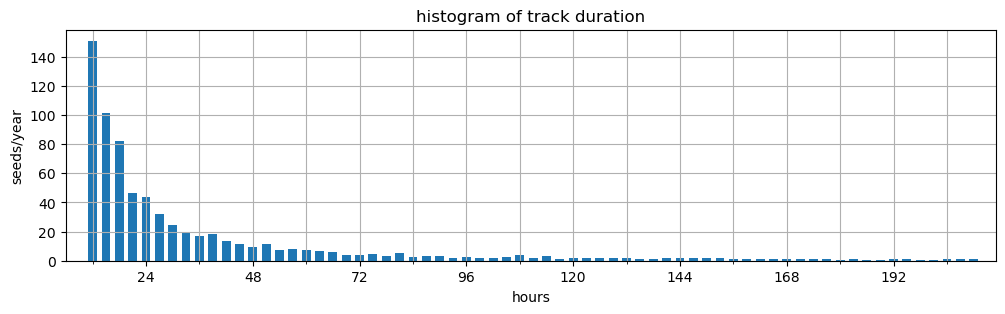

In [7]:
fig=plt.figure(figsize=(12,3))
ax = plt.axes()
track_size = ds_sd.time.notnull().sum('dtime') * 3 # track duration [hours]
hist, bins = np.histogram(track_size, np.arange(-1.5,213,3))
ax.bar((bins[1:]+bins[:-1])/2, hist/ds_sd.num_days.item()*365, width=2)
#track_size.plot.hist(ax=ax, bins=np.arange(0,9,0.25))
#_=plt.xticks(range(0,9,1))
ax.set_xticks(range(0,213,24))
ax.set_xticks(range(0,213,12), minor=True)
ax.set_xlim([6,215])
ax.grid(which='both')
ax.set_title('histogram of track duration')
ax.set_xlabel('hours')
ax.set_ylabel('seeds/year')

In [8]:
# # select Ref.001
# dsi_tc = ds_tc['Reference'].where(ds_tc['Reference'].ens==1, drop=True)
# dsi_sd = ds_sd['Reference'].where(ds_sd['Reference'].ens==1, drop=True)

# # loop through mature TCs
# for tid in dsi_tc.id.astype('int'):
#     tc = dsi_tc.sel(id=tid).isel(dtime=0)
#     time = tc.time.item() # initial TC time, try to find in seeds
#     sds = dsi_sd.where(dsi_sd.time==time, drop=True)
#     if sds.id.size == 0:
#         print(tid.item(), '-')
#         continue
#     dlon = (sds.lon - tc.lon + 540) %360 - 180
#     dlat = (sds.lat - tc.lat)
#     dist = np.sqrt(dlon**2 + dlat**2)
#     print(tid.item(), dist.min().item())

In [9]:
# select Ref.001
dsi_tc = ds_tc['Reference'].where(ds_tc['Reference'].ens==1, drop=True)
#dsi_sd = ds_sd['Reference'].where(ds_sd['Reference'].ens==1, drop=True)
dsi_sd = ds_sd

# select TC with id=200
matches = []
for tid in dsi_tc.id.astype('int')[:]:
    # tid = 20
    tc = dsi_tc.sel(id=tid).isel(dtime=0)
    time = tc.time.item()
    
    # select all final seed track points in the 12 hours prior to TC genesis
    #sds = dsi_sd.where((dsi_sd.time>=time-7) & (dsi_sd.time<=time), drop=True)
    sds = dsi_sd.where(dsi_sd.time==time, drop=True)
    if sds.id.size == 0:
        print(f"TC {int(tid):03d} X no match")
        continue
    sds = sds.isel(dtime=sds.time.argmax('dtime'))
    
    
    # calculate distance in degrees between last seed position and TC genesis position
    dlon = (sds.lon - tc.lon + 540) %360 - 180
    dlat = (sds.lat - tc.lat)
    dist = np.sqrt(dlon**2 + dlat**2)
    
    # calculate time difference between last seed occurrence and TC genesis
    dtime = tc.time - sds.time

    # loop through seed distances, in order of ascending time difference
    match = False
    for dst in dist.sortby(dtime): 
        dt = dtime.sel(id=dst.id)
        if dst < dt * 12 + 0.1: # maximum speed 12 deg/day ~55 km/h
            match = True
            matches.append(int(dst.id))
            print(f"TC {int(tid):03d} > SD {int(dst.id):04}: dist = {dst:6.2f} deg, dt = {dt:5.3f} days")
            break
    if not match:
        print(f"TC {int(tid):03d} X no match")
print(f"num matches = {len(matches)} ({len(matches)/dsi_tc.id.size*100:.1f} %)")
print(f"num unique = {len(np.unique(matches))} ({len(np.unique(matches))/dsi_tc.id.size*100:.1f} %)")

TC 001 > SD 0017: dist =   0.00 deg, dt = 0.000 days
TC 002 > SD 0018: dist =   0.00 deg, dt = 0.000 days
TC 003 > SD 0035: dist =   0.00 deg, dt = 0.000 days
TC 004 > SD 0041: dist =   0.00 deg, dt = 0.000 days
TC 005 > SD 0043: dist =   0.00 deg, dt = 0.000 days
TC 006 > SD 0046: dist =   0.00 deg, dt = 0.000 days
TC 007 > SD 0056: dist =   0.00 deg, dt = 0.000 days
TC 008 > SD 0057: dist =   0.00 deg, dt = 0.000 days
TC 009 > SD 0060: dist =   0.00 deg, dt = 0.000 days
TC 010 > SD 0072: dist =   0.00 deg, dt = 0.000 days
TC 011 > SD 0075: dist =   0.00 deg, dt = 0.000 days
TC 012 > SD 0077: dist =   0.00 deg, dt = 0.000 days
TC 013 > SD 0082: dist =   0.00 deg, dt = 0.000 days
TC 014 > SD 0084: dist =   0.00 deg, dt = 0.000 days
TC 015 > SD 0094: dist =   0.00 deg, dt = 0.000 days
TC 016 > SD 0098: dist =   0.00 deg, dt = 0.000 days


KeyboardInterrupt: 